# Performance of Bio-NICA on image sources

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from nica_algorithms import bio_nica, bio_nica_indirect, two_layer_nsm, nonnegative_pca
from util import permutation_error, add_fill_lines

### Load desired dataset

In [2]:
S = np.load('datasets/image/sources.npy')
X = np.load('datasets/image/mixtures.npy')

s_dim = S.shape[0]
x_dim = X.shape[0]
samples = S.shape[1]

### Sources

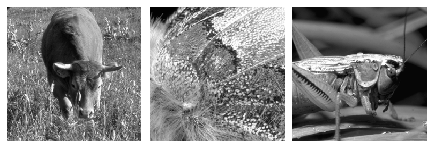

In [3]:
figure = plt.figure(figsize=(6,2))

for i in range(s_dim):
    plt.subplot(1,s_dim,i+1)
    plt.imshow(S[i].reshape(252,252), cmap="gray")
    plt.axis('off')

figure.tight_layout(pad=0.5)

plt.show()

### Mixtures

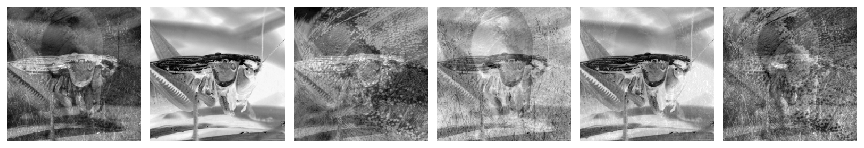

In [4]:
figure = plt.figure(figsize=(12,2))

for i in range(x_dim):
    plt.subplot(1,x_dim,i+1)
    plt.imshow(X[i].reshape(252,252), cmap="gray")
    plt.axis('off')

figure.tight_layout(pad=0.5)

plt.show()

### Bio-NICA

In [9]:
epochs = 15; iters = epochs*samples

In [10]:
trials = 10 # set the number of trials

bionica_err = np.zeros((trials,iters))
bionica_indirect_err = np.zeros((trials,iters))
# nsm_err = np.zeros((trials,iters))
# npca_err = np.zeros((trials,iters))

In [16]:
n_dim = s_dim

for i_trial in range(trials):
    
    print(f'Trial {i_trial+1} out of {trials}:')
    
    # Noncentered whitening for Nonnegative PCA

#     sig, U = np.linalg.eig(np.cov(X))

#     X_white = U@np.diag(1./np.sqrt(sig))@U.T@X
    
    n_dim = s_dim

    bionica = bio_nica(s_dim, x_dim, 'image')
    bionica_indirect = bio_nica_indirect(s_dim, x_dim, n_dim, eta0=1e-3, decay=0)
#     nsm = two_layer_nsm(s_dim, x_dim, 'image')
#     npca = nonnegative_pca(s_dim, x_dim, 'image')

    bionica_Y = np.zeros((s_dim,samples))
    bionica_Y_indirect = np.zeros((s_dim,samples))
#     nsm_Y = np.zeros((s_dim,samples))
#     npca_Y = np.zeros((s_dim,samples))

    for i_epoch in range(epochs):

        print(f'Epoch {i_epoch+1} out of {epochs}:')

        idx = np.random.permutation(samples) # random permutation

        for i_sample in range(samples):

            x = X[:,idx[i_sample]]
#             x_white = X_white[:,idx[i_sample]]
            
            bionica_Y[:,i_sample] = bionica.fit_next(x)
            bionica_Y_indirect[:,i_sample] = bionica_indirect.fit_next(x)
#             nsm_Y[:,i_sample] = nsm.fit_next(x)
#             npca_Y[:,i_sample] = npca.fit_next(x_white)

            # if a neuron hasn't fired by the 100th iteration, we flip the feedforward weights:
        
            if i_sample==100:
                for j in range(s_dim):
                    if bionica_Y[j,0:i_sample].sum()==0:
                        bionica.flip_weights(j)
                    if bionica_Y_indirect[j,0:i_sample].sum()==0:
                        bionica_indirect.flip_weights(j)
#                     if nsm_Y[j,0:i_sample].sum()==0:
#                         nsm.flip_weights(j)
#                     if npca_Y[j,0:i_sample].sum()==0:
#                         npca.flip_weights(j)

#         print(f'Recovered sources:')

        # Compute the inverse of the random permutation:

#         inv_idx = np.argsort(idx)

#         Y = bionica_Y[:,inv_idx[:]]
#         Y_indirect = bionica_Y_indirect[:,inv_idx[:]]
#         Y_nsm = nsm_Y[:,inv_idx[:]]
#         Y_npca = npca_Y[:,inv_idx[:]]

        # Display recovered sources:
        
#         print('Bio-NICA (direct):')

#         figure = plt.figure(figsize=(6,2))

#         for i in range(s_dim):
#             plt.subplot(1,s_dim,i+1)
#             plt.imshow(Y[i].reshape(252,252), cmap="gray")
#             plt.axis('off')
            
#         figure.tight_layout(pad=0.5)
        
#         plt.show()
            
#         print('Bio-NICA (indirect):')
        
#         figure = plt.figure(figsize=(6,2))

#         for i in range(s_dim):
#             plt.subplot(2,s_dim,i+1)
#             plt.imshow(Y_indirect[i].reshape(252,252), cmap="gray")
#             plt.axis('off')

#         figure.tight_layout(pad=0.5)

#         plt.show()

        print('Computing errors...')

        bionica_err[i_trial,i_epoch*samples:(i_epoch+1)*samples] = permutation_error(S[:,idx],bionica_Y)
        bionica_indirect_err[i_trial,i_epoch*samples:(i_epoch+1)*samples] = permutation_error(S[:,idx],bionica_Y_indirect)
#         nsm_err[i_trial,i_epoch*samples:(i_epoch+1)*samples] = permutation_error(S[:,idx],Y_nsm)
#         npca_err[i_trial,i_epoch*samples:(i_epoch+1)*samples] = permutation_error(S[:,idx],Y_npca)

        print(f'Bio-NICA (direct) permutation error: {bionica_err[i_trial,(i_epoch+1)*samples-1]}')
        print(f'Bio-NICA (indirect) permutation error: {bionica_indirect_err[i_trial,(i_epoch+1)*samples-1]}')
#         print(f'Final 2-layer NSM permutation error: {nsm_err[i_trial,(i_epoch+1)*samples-1]}')
#         print(f'Final Nonnegative PCA permutation error: {npca_err[i_trial,(i_epoch+1)*samples-1]}')

Trial 1 out of 10:
Epoch 1 out of 15:
Computing errors...
Bio-NICA (direct) permutation error: 1.0313195283772512
Bio-NICA (indirect) permutation error: 3.773556087853223
Epoch 2 out of 15:
Computing errors...
Bio-NICA (direct) permutation error: 0.8735633855255057
Bio-NICA (indirect) permutation error: 3.7865307599860523
Epoch 3 out of 15:
Computing errors...
Bio-NICA (direct) permutation error: 0.6674221284575561
Bio-NICA (indirect) permutation error: 3.827314845810474
Epoch 4 out of 15:
Computing errors...
Bio-NICA (direct) permutation error: 0.5691240123377301
Bio-NICA (indirect) permutation error: 3.6393692086152547
Epoch 5 out of 15:
Computing errors...
Bio-NICA (direct) permutation error: 0.5119595806651001
Bio-NICA (indirect) permutation error: 12.070959918095811
Epoch 6 out of 15:
Computing errors...
Bio-NICA (direct) permutation error: 0.4203401407039395
Bio-NICA (indirect) permutation error: 0.48495867022029593
Epoch 7 out of 15:
Computing errors...
Bio-NICA (direct) permuta

### Comparison plots

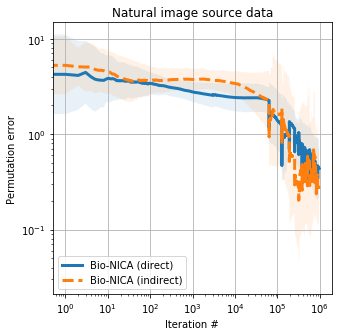

In [12]:
linewidth = 3

t = list(range(iters))

fig = plt.figure(figsize=(5,5))

ax = plt.subplot(1, 1, 1)

add_fill_lines(ax, t, bionica_err, plot_kwargs={'ls': '-', 'lw': linewidth, 'label': 'Bio-NICA (direct)'})
add_fill_lines(ax, t, bionica_indirect_err, plot_kwargs={'ls': '--', 'lw': linewidth, 'label': 'Bio-NICA (indirect)'})
# add_fill_lines(ax, t, nsm_err, plot_kwargs={'ls': '-.', 'lw': linewidth, 'label': '2-layer NSM'})
# add_fill_lines(ax, t, npca_err, plot_kwargs={'ls': ':', 'lw': linewidth, 'label': 'Nonnegative PCA'})

ax.loglog()

plt.title(f"Natural image source data")
plt.grid()
plt.legend(loc = 'lower left')
plt.xlabel('Iteration #')
plt.ylabel('Permutation error')
# plt.xlim((0,iters))
# plt.ylim(bottom=10**-4,)
# plt.ylim(10**-3,10**.8)

# plt.savefig(f'plots/{dataset}.png', dpi=300, transparent='true', bbox_inches='tight')
plt.show()